### Exercise 2

**(a)** Implement Q-Learning with for the Frozen Lake Environment of the Lecture with the following modifications: 

1. Use the $\epsilon$-greedy policy as described below for action selection. 

2. Moves to a rock cell or outside of the grid bounce the agent back to its current frozen cell and are rewarded with $-1$.

3. Rewards are 
    + $-1$ for a move to a save frozen cell, 
    + $-100$ for a move to a thin ice cell,
    + $+100$ for a move to the exit cell. 

4. The maximum number of steps within an episode is $T=100$.
    
**(b)** Apply your implementation and run Q learning for a sufficiently large number of episodes.
Plot the number of moves and the result in each episode. Results are 
+ $+1$ when the agent successfully found the exit
+ $\pm 0$ when the agent is still alive after $T$ steps 
+ $-1$ when the agent has drowned. 


**(c)** Periodically evaluate your agent's performance after every $k$-th episode. To do this, keep track of the number of moves and results as in part (b), for each possible initial state corresponding to a frozen cell. After each $k$-th episode, display the count of wins, draws, and losses, along with the average number of moves taken during wins. 

**Note:** Make sure that the action selection during evaulation follows Equation (1), as described below in the section on the $\epsilon$ greedy policy.

**(d)** Compare Q-learning with and without the $\epsilon$-greedy policy.

**The $\epsilon$-greedy policy**

In the lecture, the agent selects the next action as follows:
$$
\pi(s) = \argmax_a q(s, a),\tag{1}
$$
where the function $q(s, a)$ represents the estimated value (quality) of taking action $a$ in state $s$. This action selection policy can be problematic because it always chooses the action with the highest estimated reward, leading to a lack of exploration of other actions that might actually have higher rewards but haven't been sufficiently explored yet.

The $\epsilon$-greedy policy is an action selection strategy that alleviates the problems of choosing the next action according to Equation (1). It works as follows: 

1. With probability $1 - \epsilon$, choose the action $a$ according to Equation (1). This is known as **exploitation**.

2. With probability $\epsilon$, choose an action uniformly at random from the set of all possible actions. This is known as **exploration**.

The idea behind the $\epsilon$-greedy policy is to balance exploration and exploitation. Exploitation makes the best decision given current knowledge, while exploration gathers more knowledge at the risk of making a suboptimal decision.

The parameter $\epsilon$ controls the trade-off between exploration and exploitation. A high $\epsilon$, as typically used in the initial phase of learning, encourages more exploration (trying out different actions to see their effects), while a low $\epsilon$, as typically used in the final phase of learning, encourages more exploitation (choosing the actions that are known to yield high rewards). This balance allows the agent to learn an optimal policy over time. 

Implement an exponential annealing schedule for the exploration rate $\varepsilon$. Begin with an initial value for $\varepsilon$. After each episode, reduce $\varepsilon$ according to the following rule:

$$
\varepsilon \leftarrow \delta \cdot \varepsilon,
$$

where $\delta$ represents the decay rate. Continue to decrease $\varepsilon$ until it reaches a specified minimum value $\varepsilon_{\text{min}}$. You can use the following schedule:

+ $\varepsilon = 0.9$ as initial value
+ $\delta = 0.95$ as decay rate
+ $\varepsilon_{\text{min}} = 0.05$ as minimum value

---
### Imports

In [1]:
import numpy as np
from collections import namedtuple
from collections import defaultdict
import matplotlib.pyplot as plt

---
### Constants

In [2]:
### Cells ###
F = 0  # frozen (safe cell)
H = 1  # hole (thin ice cell)
E = 2  # exit
R = 3  # rock

### Actions ###
UP    = 0
DOWN  = 1
RIGHT = 2
LEFT  = 3

### Rewards ###
RF = -1     # reward for move to next frozen cell
RH = -100   # reward for move to hole
RE = +100   # reward for move to exit

### Final Result ###
WIN  =  1   # agent found exit
DRAW =  0   # agent is on lake
LOSS = -1   # agent is drowned


---
### Einvironment

          | 0 1 2 3 4 5  
        ---------------  
        0 | F H F F R F 
        1 | F F F F F F 
        2 | F F F R F H 
        3 | F R R R F F 
        4 | F R F F F F 
        5 | F F F R F E 

In [3]:
Transition = namedtuple(
    'transition', ('state', 'action', 'reward', 'next_state', 'done', 'result')
)

class Environment:
    def __init__(self):
        grid = np.zeros((6, 6))
        grid[5,5] = E
        grid[0,1] = H
        grid[2,5] = H
        grid[0,4] = R
        grid[2,3] = R
        grid[3,1] = R
        grid[3,2] = R
        grid[3,3] = R
        grid[4,1] = R
        grid[5,3] = R
        
        self.n_rows, self.n_cols = grid.shape
        self.nA = 4
        self.grid = grid

    # random initial state for each episode
    def initial_state(self):
        states = np.argwhere(self.grid == F)
        return tuple(states[np.random.choice(states.shape[0])])
    
    # returns result of game (win, draw, loss)
    def _result(self, state):
        cell = self.grid[state[0]][state[1]]
        if cell == E:
            return WIN
        elif cell == H:
            return LOSS
        elif cell == F:
            return DRAW
        else:
            exit('STATE ERROR: current state is invalid')

    # state-transition function
    def _next_state(self, state, action):
        if action == UP:
            s = (max(0, state[0] - 1), state[1])
        elif action == DOWN:
            s = (min(self.n_rows - 1, state[0] + 1), state[1])
        elif action == RIGHT:
            s = (state[0], min(self.n_cols - 1, state[1] + 1))
        elif action == LEFT:
            s = (state[0], max(0, state[1] - 1))
        if self.grid[s[0],s[1]] == R:
            return state
        else:
            return s 

    # reward function
    def _reward(self, state):
        if self.grid[state[0]][state[1]] == E:
            return RE
        elif self.grid[state[0]][state[1]] == H:
            return RH
        else:
            return RF
    
    # transition function
    def transition(self, state, action):
        next_state = self._next_state(state, action)
        reward = self._reward(next_state)
        result = self._result(next_state)
        done = result in [WIN, LOSS]
        return Transition(state, action, reward, next_state, done, result)

---
### Agent

In [61]:
class Agent:
    def __init__(self, 
                 env,                   # environment
                 gamma=0.9,             # discount factor
                 T=100,                 # maximum # steps per epsiode
                 epsilon=0.9,           # eps-greedy parameters
                 epsilon_min=0.05,       
                 epsilon_decay=0.95
                 ):
        self.env = env
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.T = T
        self.q_table = defaultdict(lambda: np.zeros(self.env.nA))

    # select next action using the eps-greedy policy
    def _next_action(self, state):
        if np.random.uniform(0, 1) < self.epsilon:  # exploration
            return np.random.choice(self.env.nA)  
        else:                                       # exploitation   
            q_vals = self.q_table[state]
            max_val = np.max(q_vals)
            max_idx = np.where(q_vals == max_val)[0]
            rnd_idx = np.random.choice(max_idx)
            return rnd_idx    

    # update Q-table
    def _update(self, transition):
        s, a, r, s_next, done, _ = transition
        self.q_table[s][a] = r
        if not done:
            self.q_table[s][a] += self.gamma * np.max(self.q_table[s_next])

    # anneal epsilon
    def _update_epsilon(self):
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    # q learning algorithm
    def qlearn(self, max_episodes=100, test_freq=10):
        history = []       
        test_results = []
        for episode in range(max_episodes):
            state = self.env.initial_state()
            steps, result = self.T, DRAW
            for t in range(self.T):
                action = self._next_action(state)
                transition = self.env.transition(state, action)
                self._update(transition)
                state = transition.next_state
                if transition.done: 
                    steps = t+1
                    result = transition.result
                    break
            self._update_epsilon()
            history.append((steps, result))

            if episode%test_freq == 0:
                test_results.append(self.test())
                
        return history, test_results
    
    # evaluates performance of agent on specified state
    def _apply(self, state):
        eps = self.epsilon 
        self.epsilon = -1
        steps, result = self.T, DRAW
        for t in range(self.T):
            action = self._next_action(state)
            transition = self.env.transition(state, action)
            state = transition.next_state
            if transition.done: 
                steps = t+1
                result = transition.result
                break
        self.epsilon = eps
        return steps, result
    
    # evaluates performance of agent on all possible frozen states
    def test(self):
        states = np.argwhere(self.env.grid == F)
        results = []
        for s in states:
            steps, result = self._apply(tuple(s))
            results.append((steps, result))
        return results


---
### Auxiliary Functions

In [88]:
import pandas as pd
pd.options.display.float_format = "{:.1f}".format

# print Q-table 
def print_q_table(q_table):
    df = pd.DataFrame(q_table).T
    print(df.to_string(index=False, header=False))

# plot number of steps and result of each episode
def plot_history(history):
    fig = plt.figure(1, figsize=(14, 10))
    ax = fig.add_subplot(2, 1, 1)
    episodes = np.arange(len(history))
    steps = np.array([h[0] for h in history])
    plt.plot(episodes, steps, lw=2, marker='o', markersize=6)
    ax.tick_params(axis='both', which='major', labelsize=15)
    plt.xlabel('episodes', size=18)
    plt.ylabel('# steps', size=18)
    ax = fig.add_subplot(2, 1, 2)
    results = np.array([h[1] for h in history])
    plt.step(episodes, results, lw=2)
    ax.tick_params(axis='both', which='major', labelsize=15)
    plt.xlabel('episodes', size=18)
    plt.ylabel('result', size=18)
    plt.show()

# prints progress of agent 
def print_test_results(test_results, test_freq):
    print(f'{"episode":10s}', 
              f'{"w":4s}', 
              f'{"d":4s}', 
              f'{"l":4s}', 
              f'{"steps":7s}')
    for t, results in enumerate(test_results, 1):
        steps = np.array([r[0] for r in results])
        res = np.array([r[1] for r in results])
        idx_win = np.where(np.array(res) == WIN)[0]
        n_win = len(idx_win)
        n_draw = len(np.where(np.array(res) == DRAW)[0])
        n_loss = len(np.where(np.array(res) == LOSS)[0])
        avg_steps = steps[idx_win].mean()
        print(f'{t*test_freq:7d}', 
              f'{n_win:4d}', 
              f'{n_draw:4d}', 
              f'{n_loss:4d}', 
              f'{avg_steps:7.1f}')

    

---
### Experiment 1

In [79]:
max_episodes = 200
test_freq = 10

env = Environment()
agent = Agent(env, epsilon=0.9)
history, results = agent.qlearn(max_episodes=max_episodes, test_freq=test_freq)

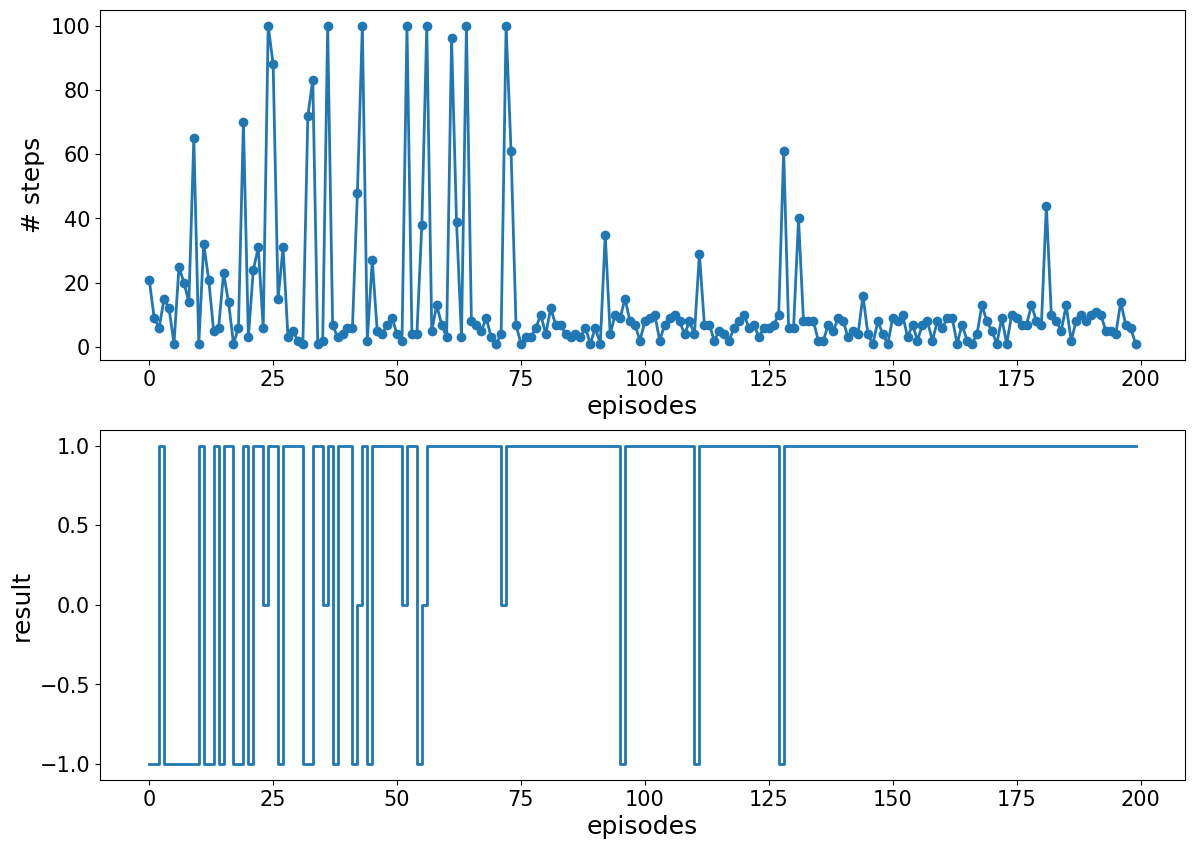

In [80]:
plot_history(history)

In [81]:
print_test_results(results, test_freq)

episode    w    d    l    steps  
     10    3    2   21     3.0
     20    3   23    0     6.0
     30    6   20    0     2.3
     40   11   15    0     3.5
     50   11   15    0     4.1
     60   15   11    0     4.5
     70   15   11    0     4.3
     80   19    7    0     4.9
     90   22    4    0     5.5
    100   22    4    0     5.5
    110   23    3    0     5.6
    120   23    3    0     5.6
    130   23    3    0     5.6
    140   23    3    0     5.6
    150   24    2    0     5.8
    160   25    1    0     6.0
    170   25    1    0     6.0
    180   25    1    0     6.0
    190   25    1    0     6.0
    200   26    0    0     6.2


---
### Experiment 2

In [85]:
env = Environment()
agent = Agent(env, epsilon=-1.0)
history, results = agent.qlearn(max_episodes=max_episodes, test_freq=test_freq)

In [86]:
print_test_results(results, test_freq)

episode    w    d    l    steps  
     10    2    0   24     4.0
     20    3   15    8     1.3
     30    7   19    0     2.7
     40   10   16    0     4.4
     50   12   14    0     6.8
     60   12   14    0     4.2
     70   12   14    0     4.0
     80   11   15    0     3.6
     90   12   14    0     3.7
    100   12   14    0     3.7
    110   12   14    0     3.7
    120   12   14    0     3.7
    130   12   14    0     3.7
    140   12   14    0     3.7
    150   12   14    0     3.7
    160   12   14    0     3.7
    170   12   14    0     3.7
    180   12   14    0     3.7
    190   12   14    0     3.7
    200   12   14    0     3.7


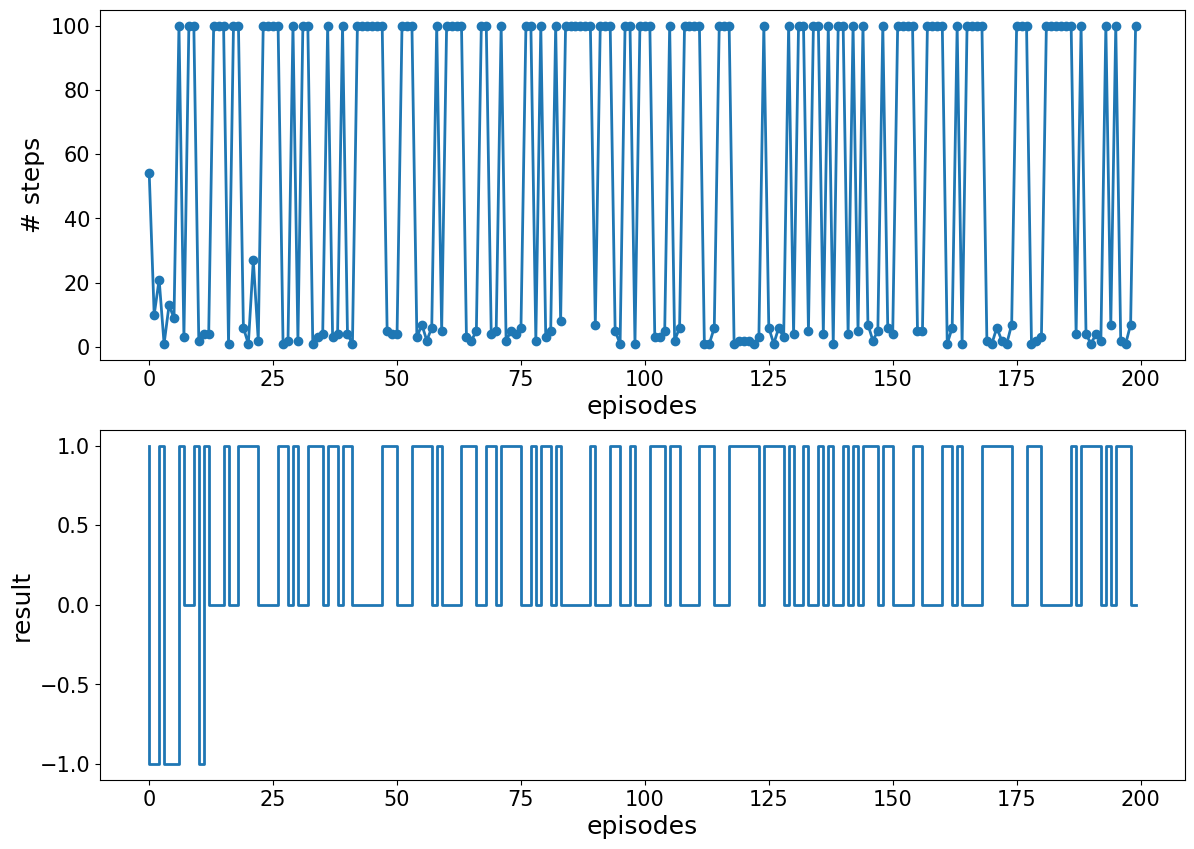

In [87]:
plot_history(history)